In [1]:
# Install needed libraries

!pip install -q tensorflow==2.2.0
!pip install -q matplotlib==3.2.2
!pip install -q numpy==1.18.5
!pip install imageio
!pip install imageio-ffmpeg

# Import the required libraries

# Tensorflow contains functions needed to build and train neural networks
import tensorflow as tf
# Matlpotlib is a plotting library to help visualize our inputs and outputs data
import matplotlib.pyplot as plt
# Numpy is a library to simplify operations on matrices and other 
# mathematical objects
import numpy as np
# Random is a library to help generate random numbers, make random choices, etc
import random


print("Libraries successfully imported!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Libraries successfully imported!


In [2]:
# Download and extract the tool tip dataset from an online repository 

DATA_URL = (
    '/content/dataset.zip'
)
path = tf.keras.utils.get_file('cholec-tinytools.zip', DATA_URL, extract=True)
  
#Stores the dataset in the variable "path"
path = path.strip('.zip')                                     

print("Dataset successfully extracted!")

Dataset successfully extracted!


In [3]:
# Define the dataset characteristics

# ~60% of the dataset for training
TRAINING_SET_SIZE = 1200      

# ~10% of the dataset for validation
VALIDATION_SET_SIZE = 200  

# ~30% of the dataset for testing                              
TEST_SET_SIZE = 599              

# The names of surgical tools we want to classify
CLASS_NAMES = ['grasper', 'hook', 'scissor', 'clipper']

# The numbers of surgical tools (i.e. classes) we want to classify     
NUMBER_CLASSES = 4                   

# Each input image will have a resolution of 86x128 pixels                        
IMAGE_SIZE = (86, 128)                        

# RGB IMAGES are represented with 3 channels (red, blue, green)                
CHANNELS = 3
   
# Number of images per batch                                               
BATCH_SIZE = 16                                              

print("Dataset characteristics defined!")

Dataset characteristics defined!


In [4]:
# Preprocess the images in the dataset

# The training images are scaled down (i.e. normalized) 
# to the range 0-1 by dividing by 255
# To artificially augment the training set, we additionally use variants of  
# each image generated by randomnly rotating it by 0-20 degrees
train_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, rotation_range=20
)
train_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/train',
    image_data_generator=train_preprocessing,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    classes=CLASS_NAMES,
    shuffle=True,
)

# The validation and test images are similarly scaled down (i.e. normalized) 
# to the range 0-1 by dividing by 255
validation_test_preprocessing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
validation_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/validation',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

test_set = tf.keras.preprocessing.image.DirectoryIterator(
    path +'/test',
    image_data_generator=validation_test_preprocessing,
    batch_size=BATCH_SIZE,
    classes=CLASS_NAMES,
    target_size=IMAGE_SIZE
)

print("\n Dataset successfully preprocessed!")

Found 1200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 599 images belonging to 4 classes.

 Dataset successfully preprocessed!


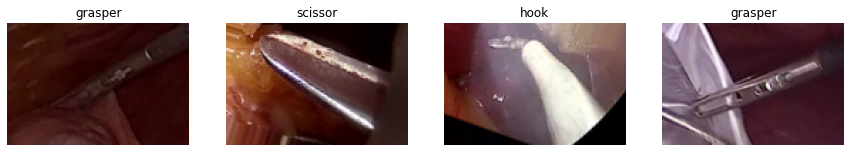

In [5]:
# Define the figure using a matplotlib.pyplot function
fig, axes = plt.subplots(1,4, figsize=(15, 15))               
random_batch =  random.randint(0, len(train_set)-1)
random_images, random_labels = train_set[random_batch]

# For loops are used to iterate over a sequence, in this case each 
# image being plotted
for image_number, axs in enumerate(axes):                     
    img = random_images[image_number]
    axs.imshow(img)
    axs.axis("off")
    axs.set_title(CLASS_NAMES[np.argmax(random_labels[image_number])])

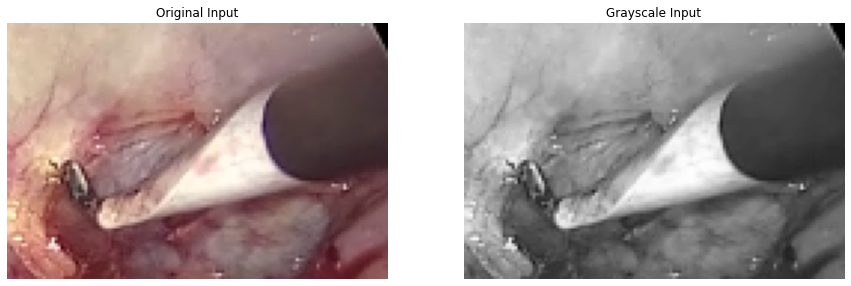

In [6]:
# Read a sample image
img = plt.imread(path + "/train/hook/7013_16226.png")

# Convert the image to grayscale
img_gray = tf.image.rgb_to_grayscale(img)

# Visualize result 
fig = plt.figure(figsize=(15,5))

# Display the original input and it's grayscale version 
fig.add_subplot(1, 2, 1); plt.imshow(img);
plt.title("Original Input"); plt.axis("off")

fig.add_subplot(1, 2, 2); plt.imshow(img_gray.numpy()[..., 0], 'gray');
plt.title("Grayscale Input"); plt.axis("off")
plt.show()

In [7]:
# Define filters for edge detection

# Horizontal filter
horizontal_edge_detector = tf.constant(
    [[1,2,1],[0,0,0],[-1,-2,-1]], dtype=tf.float32, shape=(3, 3, 1, 1)
)

# Vertical filter
vertical_edge_detector = tf.constant(
    [[1,0,-1],[2,0,-2],[1,0,-1]], dtype=tf.float32, shape=(3, 3, 1, 1)
)

# Display filters
# We use ".numpy()" to display the result as a matrix
print('Horizontal filter')
print(horizontal_edge_detector[:,:,0,0].numpy())

print('Vertical filter')
print(vertical_edge_detector[:,:,0,0].numpy())

print("Edge detectors tensors successfully defined")

Horizontal filter
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]
Vertical filter
[[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]]
Edge detectors tensors successfully defined


In [8]:
# Expand to have 4 dimensional (4D) matrix
# This is done because the tensorflow library expects the input to the 
# convolution to be in the shape Batch x Height x Width x Channels
# In this case Batch = 1

input_4d = tf.expand_dims(img_gray, 0)

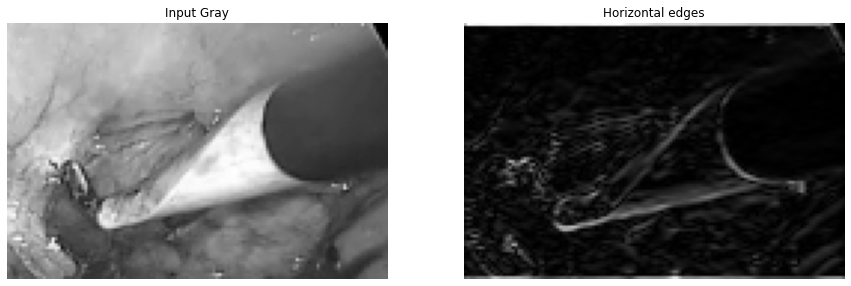

In [9]:
# Convolution on the image with horizontal filter
# The filter is shifted of 1 pixel (strides = 1) at every step, 
# zero padding is applied such the output will have the "SAME" spatial 
# dimensions as the input
conv_h = tf.nn.conv2d(input=input_4d, filters=horizontal_edge_detector, strides=1, padding="SAME") 

# The filter will output high absolute values (maybe positive or negative) 
# when it detects horizontal edges
horizontal_edge_img = tf.abs(conv_h)

# Visualize result 
fig = plt.figure(figsize=(15,5))

# Display input
fig.add_subplot(1, 2, 1); plt.imshow(input_4d.numpy()[0,:,:,0], 'gray');
plt.title("Input Gray"); plt.axis("off")

# Display detected horizontal edges
fig.add_subplot(1, 2, 2); plt.imshow(horizontal_edge_img.numpy()[0,:,:,0], 'gray');
plt.title("Horizontal edges"); plt.axis("off")

plt.show()

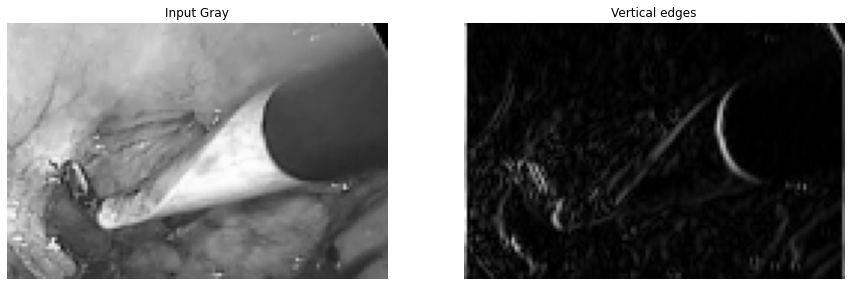

In [10]:
conv_v = tf.nn.conv2d(input=input_4d, filters=vertical_edge_detector, strides=1, padding="SAME") 
vertical_edge_img = tf.abs(conv_v)

# Visualize result 
fig = plt.figure(figsize=(15,5))

# Display input
fig.add_subplot(1, 2, 1); plt.imshow(input_4d.numpy()[0,:,:,0], 'gray');
plt.title("Input Gray"); plt.axis("off")

# Display detected vertical edges
fig.add_subplot(1, 2, 2); plt.imshow(vertical_edge_img.numpy()[0,:,:,0], 'gray');
plt.title("Vertical edges"); plt.axis("off")

plt.show()

In [11]:
# The detected edges in the horizontal and vertical direction can then be 
# combined to identify all the edges in the image 

# Create a single output by adding the detected vertical and horizontal edges
edge_detections = horizontal_edge_img + vertical_edge_img

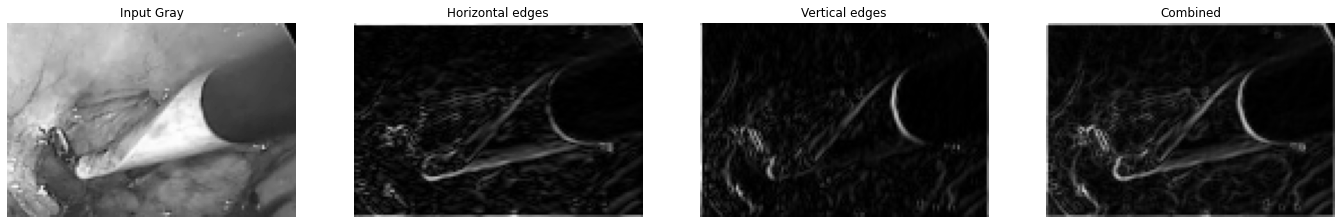

In [12]:
# Visualize result 
fig = plt.figure(figsize=(30,5))

# Display input
fig.add_subplot(1, 5, 1); plt.imshow(input_4d.numpy()[0,:,:,0], 'gray');
plt.title("Input Gray"); plt.axis("off")

# Display detected horizontal edges
fig.add_subplot(1, 5, 2); plt.imshow(horizontal_edge_img.numpy()[0,:,:,0], 'gray');
plt.title("Horizontal edges"); plt.axis("off")

# Display detected horizontal edges
fig.add_subplot(1, 5, 3); plt.imshow(vertical_edge_img.numpy()[0,:,:,0], 'gray'); 
plt.title("Vertical edges"); plt.axis("off")

# Display combined horizontal and vertical edges
fig.add_subplot(1, 5, 4); plt.imshow(edge_detections.numpy()[0,:,:,0], 'gray'); 
plt.title("Combined"); plt.axis("off")

plt.show()

In [13]:
# Again, we expand the dimensions so that our input is in the shape
# Batch x Height x Width x Channels

input_4d = tf.expand_dims(img, 0)

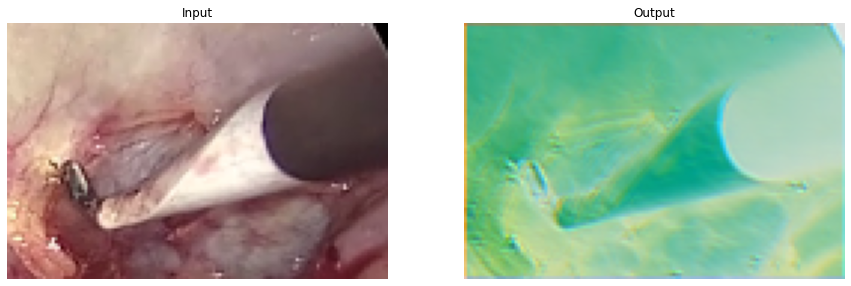

In [14]:
# Use keras for convolution

# Random convolution operation (i.e. untrained kernel weights)
conv_img = tf.keras.layers.Conv2D(
    filters=3, kernel_size=(3, 3),
    strides=1, padding="SAME",
    input_shape=(1, 86, 128, 3))(input_4d)
conv_img = conv_img.numpy()[0]

# Normalize so that our output values lie within a valid range for display
# i.e. 0-1
min, max = conv_img.min(), conv_img.max()
conv_img = (conv_img - min)/(max-min)

# Visualize result
fig = plt.figure(figsize=(15,5))

# Display input
fig.add_subplot(1, 2, 1); plt.imshow(img);plt.title("Input"); 
plt.axis("off")

# Display convolution output
fig.add_subplot(1, 2, 2); plt.imshow(conv_img);plt.title("Output");
plt.axis("off")

plt.show()

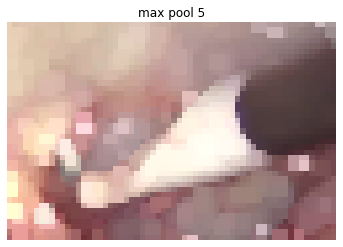

In [15]:
# Experimenting with max pooling filter sizes

# Change the value below to see how filter size affects the output
filter_size = 5

# Max Pooling using filter_size x filter_size (default: 5x5)
# The filter is shifted with a stride of 2 in both the horizontal
# and vertical directions.
maxpooled_img =  tf.keras.layers.MaxPool2D(
    pool_size=(filter_size, filter_size), strides=2)(input_4d)

# Visualize the max pooling output
fig = plt.figure()
plt.imshow(maxpooled_img.numpy()[0]);
plt.title("max pool {}".format(filter_size)); plt.axis("off")

plt.show()

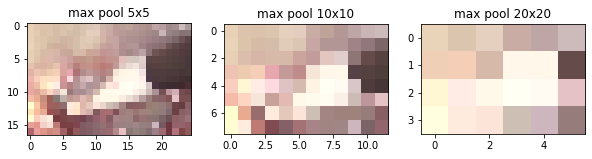

In [16]:
# Experimenting with max pooling filter sizes

# Max Pooling using 5x5 kernel, strides of 5
maxpooled_img5x5 =  tf.keras.layers.MaxPool2D(
    pool_size=(5, 5), strides=5)(input_4d)

# Max Pooling using 10x10 kernel, strides of 10
maxpooled_img10x10 = tf.keras.layers.MaxPool2D(
    pool_size=(10, 10), strides=10)(input_4d)

# Max Pooling using 20x20 kernel, strides of 20
maxpooled_img20x20 =  tf.keras.layers.MaxPool2D(
    pool_size=(20, 20), strides=20)(input_4d)

# Visualize max pooling output
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1, 3, 1); plt.imshow(maxpooled_img5x5.numpy()[0]);
plt.title("max pool 5x5")

fig.add_subplot(1, 3, 2); plt.imshow(maxpooled_img10x10.numpy()[0])
plt.title("max pool 10x10")

fig.add_subplot(1, 3, 3); plt.imshow(maxpooled_img20x20.numpy()[0]);
plt.title("max pool 20x20")

plt.show()

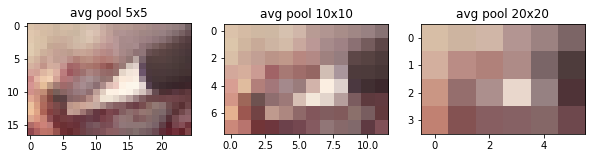

In [17]:
# Experimenting with average pooling filter sizes

# Average Pooling using 5x5 kernel, stride of 5
avgpooled_img5x5 = tf.keras.layers.AveragePooling2D(
    pool_size=(5, 5), strides=5)(input_4d)

# Average Pooling using 10x10 kernel, stride of 10
avgpooled_img10x10 = tf.keras.layers.AveragePooling2D(
    pool_size=(10, 10), strides=10)(input_4d)

# Average Pooling using 20x20 kernel, strides of 20
avgpooled_img20x20 = tf.keras.layers.AveragePooling2D(
    pool_size=(20, 20), strides=20)(input_4d)

# Visualize average pooling output
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1, 3, 1); plt.imshow(avgpooled_img5x5.numpy()[0]);
plt.title("avg pool 5x5")

fig.add_subplot(1, 3, 2); plt.imshow(avgpooled_img10x10.numpy()[0]);
plt.title("avg pool 10x10")

fig.add_subplot(1, 3, 3); plt.imshow(avgpooled_img20x20.numpy()[0]);
plt.title("avg pool 20x20")

plt.show()


In [18]:
# Defining the neural network architecture
model = tf.keras.Sequential()

# Adding a convolution with 16 5x5 filters followed by a ReLU activation
model.add(tf.keras.layers.Conv2D(
    filters=16, kernel_size=5, activation="relu", input_shape=(86, 128, 3))
)
# Adding max pooling over 5x5 patches of the previous layers output
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5,5)))     

# Adding a second convolution with 32 3x3 filters followed by a ReLU activation                   
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")) 

# Adding a layer to flatten the multidimensional (HxWxC) input
model.add(tf.keras.layers.Flatten())                           

# Adding a fully connected layer with 4096 outputs followed by a ReLU activation                 
model.add(tf.keras.layers.Dense(units=4096, activation="relu"))                 

# Adding a fully connected layer with 2048 outputs followed by a ReLU activation
model.add(tf.keras.layers.Dense(units=2048, activation="relu"))       

# Adding a fully connected layer with 4 outputs followed by a softmax activation          
model.add(tf.keras.layers.Dense(units=NUMBER_CLASSES, activation="softmax"))    

print("Neural network architecture successfully defined!")

Neural network architecture successfully defined!


In [19]:
# Defining the optimization method, a loss function and a metric

# The optimization method is stochasitc gradient descent(SGD)
opt = tf.keras.optimizers.SGD(learning_rate=0.01) 

# We specify the expected input shape to build our model 
# batch size x height x width x channels                   
model.build([1, 86, 128, 3])

# Categorical cross entropy is commonly used loss for classification problems
model.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']
)

# model.summary generates a neat summary listing the number of parameters
# in the entire network and per layer
model.summary()       

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 82, 124, 16)       1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 22, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 9856)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              40374272  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8

Input:


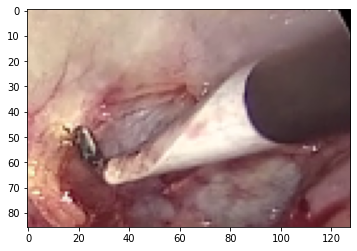

Output:
[0.26320186 0.22276217 0.25462586 0.25941005]
['grasper', 'hook', 'scissor', 'clipper']


In [20]:
# Read image
img = plt.imread(path + "/train/hook/7013_16226.png")
print('Input:')
plt.imshow(img)
plt.show()

# Expand to have 4 dimensional (4D) image tensor
input_4d = tf.expand_dims(img, 0)

# Uses the untrained model defined above to predict  
prediction = model.predict(input_4d)                                   
print('Output:')
print(prediction[0])
print(CLASS_NAMES)

Epoch 1/15
75/75 [==============================] - 53s 712ms/step - loss: 1.1551 - accuracy: 0.5158 - val_loss: 0.9792 - val_accuracy: 0.5950
Epoch 2/15
75/75 [==============================] - 36s 482ms/step - loss: 0.9003 - accuracy: 0.6483 - val_loss: 0.7844 - val_accuracy: 0.7000
Epoch 3/15
75/75 [==============================] - 36s 482ms/step - loss: 0.7788 - accuracy: 0.7125 - val_loss: 0.7100 - val_accuracy: 0.7150
Epoch 4/15
75/75 [==============================] - 38s 501ms/step - loss: 0.7289 - accuracy: 0.7333 - val_loss: 0.7385 - val_accuracy: 0.7100
Epoch 5/15
75/75 [==============================] - 45s 595ms/step - loss: 0.6444 - accuracy: 0.7733 - val_loss: 0.6776 - val_accuracy: 0.7500
Epoch 6/15
75/75 [==============================] - 36s 486ms/step - loss: 0.5691 - accuracy: 0.7975 - val_loss: 0.5373 - val_accuracy: 0.7800
Epoch 7/15
75/75 [==============================] - 37s 487ms/step - loss: 0.5332 - accuracy: 0.8200 - val_loss: 0.5940 - val_accuracy: 0.7750

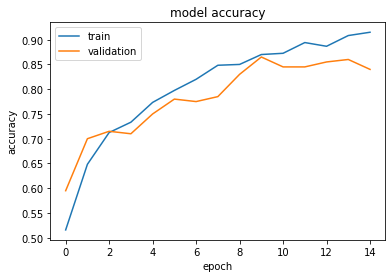

In [21]:
# Training our neural network
# The model will iterate over the training data 15 times (i.e. epochs)
history = model.fit(train_set, validation_data=validation_set, epochs=15)       

# Plot the validation and test results for each training epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [22]:
 model.evaluate(test_set)

38/38 [==============================] - 4s 113ms/step - loss: 0.3940 - accuracy: 0.8681


[0.3940301239490509, 0.8681135177612305]

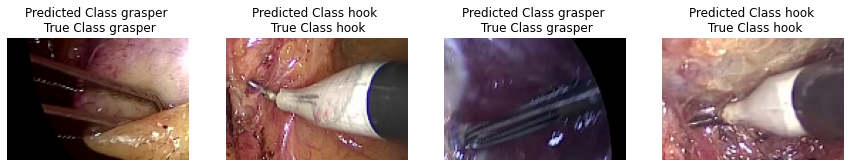

In [23]:
# Define the figure using a matplotlib.pyplot function
fig, axes = plt.subplots(1,4, figsize=(15, 15))               
random_batch =  random.randint(0, len(test_set)-1)
random_images, random_labels = test_set[random_batch]

predictions = model.predict(random_images)

# For loops are used to iterate over a sequence, in this case each 
# image being plotted
for image_number, axs in enumerate(axes):                     
    img = random_images[image_number]
    axs.imshow(img)
    axs.axis("off")
    prediction = CLASS_NAMES[np.argmax(predictions[image_number])]
    label = CLASS_NAMES[np.argmax(random_labels[image_number])]
    axs.set_title("Predicted Class {} \n True Class {}".format(prediction, label))

In [24]:
my_model = tf.keras.Sequential()
my_model.add(
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation="relu")
)
my_model.add(tf.keras.layers.MaxPooling2D(pool_size=(5,5)))
my_model.add(
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")
)
my_model.add(tf.keras.layers.Flatten())
my_model.add(tf.keras.layers.Dense(units=4096, activation="relu"))
my_model.add(tf.keras.layers.Dense(units=2048, activation="relu"))
my_model.add(tf.keras.layers.Dense(units=NUMBER_CLASSES, activation="softmax"))

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
my_model.compile(
    optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']
)

history = my_model.fit(train_set, validation_data=validation_set, epochs=15)

Epoch 1/15
75/75 [==============================] - 37s 493ms/step - loss: 1.0630 - accuracy: 0.5483 - val_loss: 1.0640 - val_accuracy: 0.5850
Epoch 2/15
75/75 [==============================] - 36s 484ms/step - loss: 0.8349 - accuracy: 0.6725 - val_loss: 0.7460 - val_accuracy: 0.6900
Epoch 3/15
75/75 [==============================] - 37s 491ms/step - loss: 0.7334 - accuracy: 0.7367 - val_loss: 0.8133 - val_accuracy: 0.6600
Epoch 4/15
75/75 [==============================] - 41s 552ms/step - loss: 0.6960 - accuracy: 0.7625 - val_loss: 0.6732 - val_accuracy: 0.7500
Epoch 5/15
75/75 [==============================] - 37s 488ms/step - loss: 0.6285 - accuracy: 0.7825 - val_loss: 0.5495 - val_accuracy: 0.8100
Epoch 6/15
75/75 [==============================] - 36s 482ms/step - loss: 0.5484 - accuracy: 0.8242 - val_loss: 0.5074 - val_accuracy: 0.8250
Epoch 7/15
75/75 [==============================] - 37s 493ms/step - loss: 0.5403 - accuracy: 0.8258 - val_loss: 0.4994 - val_accuracy: 0.8350

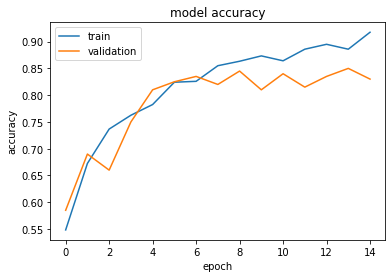

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [26]:
my_model.evaluate(test_set)

38/38 [==============================] - 4s 114ms/step - loss: 0.4194 - accuracy: 0.8531


[0.41935107111930847, 0.8530884981155396]